# RISS 논문에서 명사 키워드를 분석
## 데이터 준비

In [46]:
import pandas as pd
import glob
import re
from functools import reduce
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

### [데이터조합 - 파일 병합하기]

In [47]:
all_files = glob.glob('./data/myCabinetExcelData*.xls')
# glob.glob() : 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환

all_files

['./data\\myCabinetExcelData (1).xls',
 './data\\myCabinetExcelData (2).xls',
 './data\\myCabinetExcelData (3).xls',
 './data\\myCabinetExcelData (4).xls',
 './data\\myCabinetExcelData (5).xls',
 './data\\myCabinetExcelData (6).xls',
 './data\\myCabinetExcelData (7).xls',
 './data\\myCabinetExcelData (8).xls',
 './data\\myCabinetExcelData (9).xls']

In [48]:
all_files_data = [] #저장할 리스트
for file in all_files:  
    data_frame = pd.read_excel(file) 
    #pd.read_excel() : all_files 리스트에 있는 파일 이름을 이용해 엑셀파일을 읽어옴
    
    all_files_data.append(data_frame) #DataFrame여러개가 연결된 list
    # append() : 파일 내용을 all_files_data에 추가

all_files_data[0] #0번째 페이지내용 확인

,Unnamed: 0,번호,제목,저자,출판사,출판일
0,NaN,1,Guest Editorial: Big Media Data: Understanding...,"Wang, J.; Qi, G.; Sebe, N.; Aggarwal, C. C.",unknown,2015
1,NaN,2,Guest Editorial: Big Scholar Data Discovery an...,"Lin, Y.; Tong, H.; Tang, J.; Candan, K. S.",unknown,2016
2,NaN,3,Guest Editorial: Big Data Analytics and the Web,"Sheng, M.; Vasilakos, A. V.; Yu, Q.; You, L.",unknown,2016
3,NaN,4,Parallel computing for preserving privacy usin...,"Yaji, Sharath; Neelima, B.",Inderscience,2018
4,NaN,5,NoSQL databases for big data,"Oussous, Ahmed; Benjelloun, Fatima-Zahra; Lahc...",Inderscience,2017
...,...,...,...,...,...,...
95,NaN,96,Smart city big data analytics: An advanced review,"Soomro, Kamran; Bhutta, Muhammad Nasir Mumtaz;...",John Wiley & Sons Ltd,2019
96,NaN,97,A watchdog approach - name-matching algorithm ...,"Kirubakaran, Anusuya; Aramudhan, M.",Inderscience,2018
97,NaN,98,An intelligent approach to Big Data analytics ...,"Verma, Neha; Singh, Jatinder",Emerald Group Publishing Limited,2017
98,NaN,99,How organisations leverage Big Data: a maturit...,"Comuzzi, Marco; Patel, Anit",Emerald Group Publishing Limited,2016


In [49]:
all_files_data_concat = pd.concat(all_files_data, axis = 0, ignore_index = True) 
# axis=0 : all_files_data를 세로축을 기준으로 병합(concat)하여 all_files_data_concat리스트에 저장
# ignore_index = True : 기존 index 무시

all_files_data_concat   #출력하여 내용 확인
# 9개의 페이지 내용이 다 합쳐져서 900 rows가 됨.

,Unnamed: 0,번호,제목,저자,출판사,출판일
0,NaN,1,Guest Editorial: Big Media Data: Understanding...,"Wang, J.; Qi, G.; Sebe, N.; Aggarwal, C. C.",unknown,2015
1,NaN,2,Guest Editorial: Big Scholar Data Discovery an...,"Lin, Y.; Tong, H.; Tang, J.; Candan, K. S.",unknown,2016
2,NaN,3,Guest Editorial: Big Data Analytics and the Web,"Sheng, M.; Vasilakos, A. V.; Yu, Q.; You, L.",unknown,2016
3,NaN,4,Parallel computing for preserving privacy usin...,"Yaji, Sharath; Neelima, B.",Inderscience,2018
4,NaN,5,NoSQL databases for big data,"Oussous, Ahmed; Benjelloun, Fatima-Zahra; Lahc...",Inderscience,2017
...,...,...,...,...,...,...
895,NaN,96,Layered software patterns for data analysis in...,"Hakeem, H.",Springer Science + Business Media,2017
896,NaN,97,"GPU-DAEMON: GPU algorithm design, data managem...","Awan, Muaaz Gul; Eslami, Taban; Saeed, Fahad","Elsevier Science B.V., Amsterdam.",2018
897,NaN,98,U.S. Government BETS Big on Data: A multi-agen...,"Seffers, G.I.",AFCEA ARMED FORCES COMMUNICATIONS AND,2013
898,NaN,99,Tuning small analytics on Big Data: Data parti...,"Romero, Oscar; Herrero, Victor; Abelló, Albert...","Elsevier Science B.V., Amsterdam.",2015


In [50]:
# all_files_data_concat.to_csv('./data/riss_bigdata.csv', encoding = 'utf-8', index = False)
# all_files_data_concat을 CSV 파일로 저장

### [데이터 전처리]
*수집한 데이터에서 제목을 추출

In [51]:
all_title = all_files_data_concat['제목'] 
# all_files_data_concat의 컬럼 중에서 분석에 사용할 ‘제목’ 컬럼만 추출해 all_title에 저장

all_title

0      Guest Editorial: Big Media Data: Understanding...
1      Guest Editorial: Big Scholar Data Discovery an...
2        Guest Editorial: Big Data Analytics and the Web
3      Parallel computing for preserving privacy usin...
4                           NoSQL databases for big data
                             ...                        
895    Layered software patterns for data analysis in...
896    GPU-DAEMON: GPU algorithm design, data managem...
897    U.S. Government BETS Big on Data: A multi-agen...
898    Tuning small analytics on Big Data: Data parti...
899    Opportunities and challenges of big data for t...
Name: 제목, Length: 900, dtype: object

In [52]:
stopWords = set(stopwords.words("english"))
# stopwords.words(“English”) : 
# nltk.corpus이 제공한 영어 불용어(사용하지 않는 단어목록)을 불러와 set배열로 저장

lemma = WordNetLemmatizer()
# 표제어(어근단어=기본 사전형 단어) 추출 작업을 제공하는 WordNetLemmatizer 객체를 생성

words = [] 
for title in all_title: 
    EnWords = re.sub(r"[^a-zA-Z]+", " ", str(title)) 
    # re : 정규 표현식 라이브러리 / sub(패턴, 교체할 문자열, 문자열) : 패턴은 정규표현식
    # all_title의 제목에 대해 정규식으로 만든 규칙을 적용하여 
    # 알파벳 으로 시작하지 않는 단어"[^a-zA-Z]+"는 공백으로 치환하여re.sub( ) 제거

    EnWordsToken = word_tokenize(EnWords.lower()) 
    # 소문자로 정규화 하고lower( ), 단어 토큰화word_tokenize( )를 함
    # word_tokenize : 스페이스, 구두점으로 분해 및 단어 축약형 분해
    # ex) can’t -> ca, n’t

    EnWordsTokenStop = [w for w in EnWordsToken if w not in stopWords] 
    EnWordsTokenStopLemma = [lemma.lemmatize(w) for w in EnWordsTokenStop]  
    # 불용어stopWords를 제거한 후에 표제어(어근 단어) 추출lemmatize(w)을 한다
    words.append(EnWordsTokenStopLemma)

print(words[:10]) 

[['guest', 'editorial', 'big', 'medium', 'data', 'understanding', 'search', 'mining', 'part'], ['guest', 'editorial', 'big', 'scholar', 'data', 'discovery', 'collaboration'], ['guest', 'editorial', 'big', 'data', 'analytics', 'web'], ['parallel', 'computing', 'preserving', 'privacy', 'using', 'k', 'anonymisation', 'algorithm', 'big', 'data'], ['nosql', 'database', 'big', 'data'], ['computation', 'migration', 'new', 'approach', 'execute', 'big', 'data', 'bioinformatics', 'workflow'], ['towards', 'real', 'time', 'big', 'data', 'analytics', 'platform', 'health', 'application'], ['new', 'approach', 'accurate', 'distributed', 'cluster', 'analysis', 'big', 'data', 'competitive', 'k', 'mean'], ['five', 'layer', 'architecture', 'big', 'data', 'processing', 'analytics'], ['towards', 'max', 'min', 'fair', 'resource', 'allocation', 'stream', 'big', 'data', 'analytics', 'shared', 'cloud']]


In [53]:
words2 = list(reduce(lambda x, y: x+y, words))
# reduce : 전처리가 끝난 words는 2차원 리스트이므로 reduce()함수를 사용하여 1차원 리스트로 변환

print(words2[:10])

['guest', 'editorial', 'big', 'medium', 'data', 'understanding', 'search', 'mining', 'part', 'guest']


***

**파이썬공부**
1. reduce(함수, iterable)
- iterable의 각 요소를 지정된 함수로 처리한 뒤 이전 결과와 누적해서 반환
```
words = [['1','2'], ['3'], ['4', '5']]
words2 = list(reduce(lambda x, y: x+y, words))
print(words2)     

>>>['1', '2', '3', '4', '5']
```

2. Lambda 매개변수 : 표현식
- 매개변수를 표현식대로 처리해서 출력
- 위에서 사용한 `람다 : x, y, X+Y`
- -> 두 배열이 합쳐지면서 하나로 합쳐짐. 단순한 덧셈연산으로 처리되면서 하나로 들어감

***


## 데이터 탐색 및 분석 모델 구축
### [데이터 탐색]
*단어 빈도 구하고, 히스토그램 그리기

In [ ]:
count = Counter(words2)
# Counter() : words2 리스트에 있는 단어별로 출현 횟수를 계산하여 딕셔너리 객체인 count를 생성

# Counter의 처음 5개 항목만 출력
# for word, count in list(count.items())[:5]:
#    print(word, count)

In [58]:
word_count = dict()
for tag, counts in count.most_common(50):
    if(len(str(tag))>1):
        word_count[tag] = counts
        print("%s : %d" % (tag, counts))

# 출현 횟수가 많은 상위 50개 단어 중에서 단어 길이가 1보다 큰 것만 [word_count] 딕셔너리에 저장한 후 출력
# 글자들 중 1개 짜리 글자는 의미가 없음. 그래서 1보다 큰것만 word_count에 넣음
# 데이터의 개수가 많은 순으로 정렬된 배열을 리턴

data : 1530
big : 1250
analytics : 121
analysis : 60
based : 53
using : 52
management : 47
system : 46
science : 44
challenge : 41
approach : 40
mining : 37
research : 34
new : 33
model : 33
smart : 33
health : 32
cloud : 31
learning : 30
opportunity : 29
processing : 27
small : 27
technology : 26
application : 24
framework : 24
computing : 23
social : 23
network : 23
information : 23
quality : 22
deal : 22
use : 22
driven : 21
knowledge : 21
storage : 20
era : 20
platform : 19
healthcare : 19
service : 19
efficient : 19
process : 19
open : 19
distributed : 18
large : 18
review : 18
perspective : 18
privacy : 17
algorithm : 17
environment : 17
issue : 17


In [59]:
del word_count['big']
del word_count['data']
# 특정단어를 제거한 뒤 히스토그램 그리기
# 검색어였기에 당연히 1000개 이상으로 많은 ‘big’과 ‘data’를 제거
# -> 뒷 순위것을 더 명확하게 구분할 수 있게 됨.

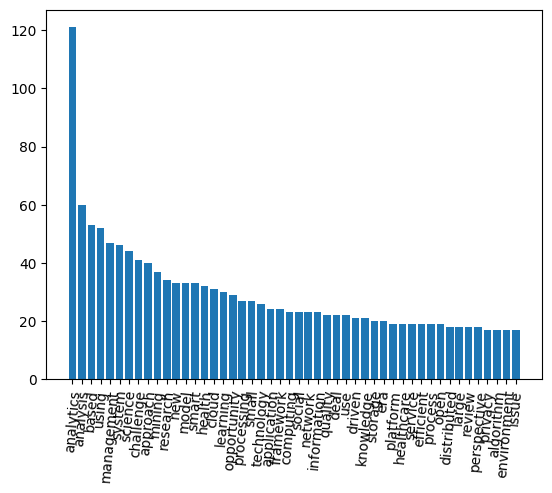

In [60]:
# 상위 50개만 저장한 word_count 딕셔너리에서 
# x축 값으로 사용할 [sorted_Keys]와 
# y축 값으로 사용할 [sorted_Values]를 
# 가장 많이 나온 단어부터 보기위해 역순으로 정렬함. [reverse=True]

sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
# get함수 : Key(=단어)에 대응되는 Value(=빈도)를 리턴

sorted_Values = sorted(word_count.values(), reverse = True)

plt.bar(range(len(word_count)), sorted_Values, align = 'center')
# 일단 word_count의 개수만큼 x축을 비워넣고 그려줌

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = 85)
# xticks를 이용해서 x축 글자추가 / rotation(글자기울기)=85
# x축 눈금plt.xticks은 sorted_Keys 리스트의 값(상위 50개 단어)을 순서대로 사용

plt.show()

## 결과 시각화
### [그래프 그리기]

In [61]:
all_files_data_concat['doc_count'] = 0 
summary_year = all_files_data_concat.groupby('출판일', as_index = False)['doc_count'].count()
# all_files_data_concat에 doc_count 컬럼을 추가한 뒤 
# ‘출판일’ 컬럼을 기준 으로 그룹을 만들고 [groupby( )], 
# 그룹별 데이터 개수 [count( )]를 doc_count 컬럼에 저장하여 summary_year 리스트를 생성

# doc_count를 세는 이유: 컬럼 표시 편의를 위함임. 
# 출판일별로 논문 몇 개 나왔는지 세고 싶어서. ‘출판사’로 바꾸어도 동일 결과
summary_year 

,출판일,doc_count
0,1994,1
1,1995,1
2,1996,1
3,1998,3
4,2002,4
5,2003,1
6,2004,3
7,2005,3
8,2007,2
9,2008,3


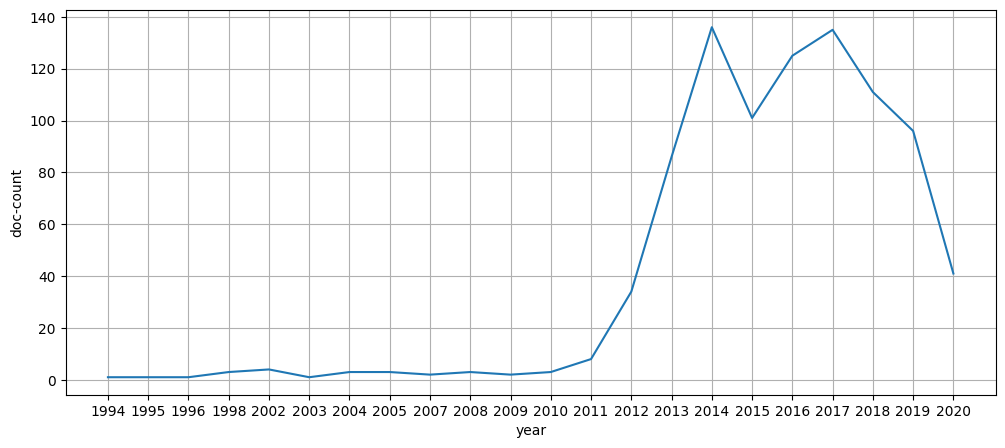

In [62]:
plt.figure(figsize = (12, 5))
plt.xlabel("year")
plt.ylabel("doc-count")
plt.grid(True)
plt.plot(range(len(summary_year)), summary_year['doc_count'])
# range()는 0, 1, 2, ,,, 전체연도 개수만큼 만듦 
# summary_year의 doc_count 컬럼을 차트의 y축으로 설정
plt.xticks(range(len(summary_year)), [text for text in summary_year['출판일']])
# ‘출판일’ 컬럼은 x축으로 설정하여 plt.xticks( ) 차트를 그림

plt.show()

### [워드 클라우드 그리기]

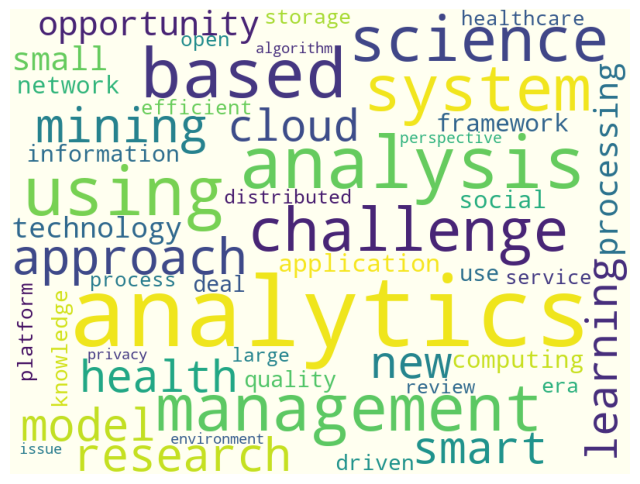

In [63]:
stopwords = set(STOPWORDS)
# 워드클라우드에서 처리할 불용어를 설정

wc = WordCloud(background_color = 'ivory', stopwords = stopwords, width = 800, height = 600)
# 워드클라우드 객체를 생성
# 불용어처리 과정 : 전처리 했으므로 생략가능

cloud = wc.generate_from_frequencies(word_count)
# 워드클라우드 객체인 wc에 word_count 데이터를 담아서 cloud 객체를 생성
# 빈도수를 통하여 이미지를 생성해주는 함수. 파라미터로 단어:빈도수 형태 dict형 입력

plt.figure(figsize = (8,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# cloud.to_file("riss_bigdata_wordCloud.jpg")  #jpg파일로 저장